# Validation of the NuFeb model fitting for S. elongatus


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.integrate import odeint
from glob import glob
import pickle
from sklearn.linear_model import LinearRegression
from pathlib import Path
from nufeb_tools import utils,plot
import seaborn as sns


Import validation simulation data

In [3]:
BASE_DIR = Path(f'../simulation-data/axenic-se/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

Import experimental data

In [4]:
SucroseMW = 342.3
ExpPath = f'../experimental-data/Biomass CscB-SPS original strain.xlsx'
Experimental = pd.read_excel(ExpPath,sheet_name='Compiled')
Experimental.loc[:,'Sucrose_mM'] =Experimental.loc[:,'Sucrose']/SucroseMW*1e3
test_data = pd.read_excel('../experimental-data/sucrose-OD-IPTG-sweep.xls',sheet_name='reps')


Use nufeb-tools to collect data from all simulation folders listed above

In [188]:
data = [utils.get_data(directory=str(x)) for x in folders]

Compile datasets into one dataframe

In [105]:
Volume = np.prod(data[0].metadata['Dimensions'])
CellNum2OD = Volume*1e6/0.3e-8

dfs = []
for x in data:
    temp = pd.concat([x.ntypes.cyano/CellNum2OD,x.ntypes.step/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True),x.biomass.cyano.reset_index(drop=True)],axis=1)
    temp.columns=['OD750','Hours','Sucrose','Biomass']
    temp['IPTG'] = x.metadata['SucRatio']
    temp.Biomass = temp.Biomass/1e18/Volume
    temp['SucroseMass']=temp.Sucrose*SucroseMW/1e3
    temp['TotalBiomass'] = temp.Biomass + temp.SucroseMass
    temp['RelativeBiomass'] = temp.Biomass/temp.TotalBiomass
    temp['RelativeSucrose'] = temp.SucroseMass/temp.TotalBiomass
    dfs.append(temp)
df = pd.concat(dfs,ignore_index=True)
#df = df.loc[(df.Hours > 23.8) & (df.Hours < 24)]
#df.sort_values(by='IPTG',inplace=True)
#df.reset_index(inplace=True)
df.head()

,OD750,Hours,Sucrose,Biomass,IPTG,SucroseMass,TotalBiomass,RelativeBiomass,RelativeSucrose
0,0.300,0.000000,9.991236e-20,0.092662,0.0,3.420000e-20,0.092662,1.0,3.690826e-19
1,0.300,0.277778,4.094905e-20,0.094470,0.0,1.401686e-20,0.094470,1.0,1.483734e-19
2,0.300,0.555556,3.039170e-20,0.096313,0.0,1.040308e-20,0.096313,1.0,1.080128e-19
3,0.303,0.833333,2.836254e-20,0.098193,0.0,9.708497e-21,0.098193,1.0,9.887201e-20
4,0.306,1.111111,3.014517e-20,0.100108,0.0,1.031869e-20,0.100108,1.0,1.030752e-19


In [210]:
test_data

,IPTG,OD750,Sucrose
0,0.000,1.38,0.026140
1,0.005,1.40,0.103470
2,0.010,1.50,0.447660
3,0.020,1.37,1.253680
4,0.050,1.24,2.199110
...,...,...,...
58,0.050,NaN,NaN
59,0.100,NaN,NaN
60,0.200,NaN,NaN
61,0.500,NaN,NaN


Make a dataframe for 24 hr data to match some of the experimental data

In [107]:
df24 = df.loc[(df.Hours > 23.8) & (df.Hours < 24)]
df24.sort_values(by='IPTG',inplace=True)
df24.reset_index(inplace=True)
df24.head()

C:\Users\Jonathan\anaconda3\envs\nufeb\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,index,OD750,Hours,Sucrose,Biomass,IPTG,SucroseMass,TotalBiomass,RelativeBiomass,RelativeSucrose
0,86,1.476,23.888889,2.973211e-20,0.488220,0.0,1.017730e-20,0.488220,1.0,2.084572e-20
1,174,1.386,23.888889,2.965110e-20,0.469635,0.0,1.014957e-20,0.469635,1.0,2.161159e-20
2,438,1.464,23.888889,2.970266e-20,0.491192,0.0,1.016722e-20,0.491192,1.0,2.069907e-20
3,526,1.410,23.888889,2.969074e-20,0.482621,0.0,1.016314e-20,0.482621,1.0,2.105823e-20
4,878,1.371,23.888889,2.971957e-20,0.459599,0.0,1.017301e-20,0.459599,1.0,2.213453e-20


In [119]:
Experimental.head()

,Time,OD750,IPTG,Biomass,Sucrose,Total Biomass,% Sucrose,% Biomass,Biomass Ratio,Sucrose_mM
0,0,0.271,0.0,0.075790,0.020914,0.096704,0.216271,0.783729,0.275951,0.061099
1,0,0.300,0.0,0.090530,0.031371,0.121901,0.257351,0.742649,0.346531,0.091649
2,0,0.270,0.0,0.077890,0.027108,0.104998,0.258176,0.741824,0.348029,0.079194
3,6,0.440,0.0,0.130530,0.028273,0.158803,0.178038,0.821962,0.216602,0.082597
4,6,0.396,0.0,0.136842,0.027111,0.163953,0.165359,0.834641,0.198120,0.079203


In [110]:
Experimental.IPTG.unique()

array([0.  , 0.01, 1.  ])

Helper function to make the figure panel labels

In [173]:

from matplotlib import transforms
def label_panel(ax, letter, *,
                offset_left=0.3, offset_up=0.1, prefix='', postfix='', **font_kwds):
    kwds = dict(fontsize=18)
    kwds.update(font_kwds)
    # this mad looking bit of code says that we should put the code offset a certain distance in
    # inches (using the fig.dpi_scale_trans transformation) from the top left of the frame
    # (which is (0, 1) in ax.transAxes transformation space)
    fig = ax.figure
    trans = ax.transAxes + transforms.ScaledTranslation(-offset_left, offset_up, fig.dpi_scale_trans)
    ax.text(0, 1, prefix+letter+postfix, transform=trans, **kwds)

Plot figure

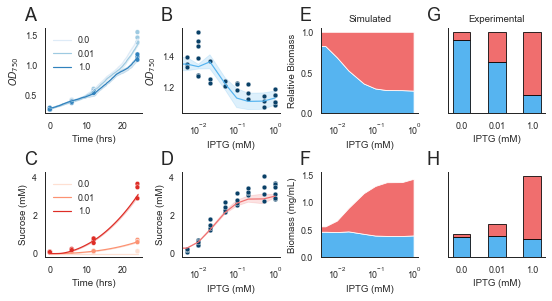

In [189]:
fig = plt.figure(constrained_layout=True, figsize=(7.5,4))
gs0 = gridspec.GridSpec(2, 4, figure=fig)
sns.set_context('paper')
sns.set_style('white')

#colors
od_pal = ['#deebf7','#9ecae1','#3182bd']
suc_pal = ['#fee0d2','#fc9272','#de2d26']#['#094067','#90b4ce','#5f6c7b']#['#3da9fc','#ef4565','#5f6c7b']
c_suc=['#56B4F0','#F06E6E']
c_exp = '#094067'

# OD vs time
ax1 = fig.add_subplot(gs0[0, 0])
sns.lineplot(x='Hours',y='OD750',hue='IPTG',ci='sd',data=df[(df.IPTG==0) | (df.IPTG==0.01) | (df.IPTG==1)],ax=ax1,palette=od_pal)
sns.scatterplot(x='Time',y='OD750',hue='IPTG',ci='sd',data=Experimental,ax=ax1,palette=od_pal,legend=False)
ax1.legend(frameon=False)
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel(r'$OD_{750}$')

# Sucrose vs time
ax2 = fig.add_subplot(gs0[1, 0])
sns.lineplot(x='Hours',y='Sucrose',hue='IPTG',ci='sd',data=df[(df.IPTG==0) | (df.IPTG==0.01) | (df.IPTG==1)],palette=suc_pal,ax=ax2)
sns.scatterplot(x='Time',y='Sucrose_mM',hue='IPTG',ci='sd',data=Experimental,ax=ax2,palette=suc_pal,legend=False)
ax2.legend(frameon=False)
ax2.set_xlabel('Time (hrs)')
ax2.set_ylabel('Sucrose (mM)')

# OD vs IPTG @ 24 hrs
ax3 = fig.add_subplot(gs0[0, 1])
sns.lineplot(x='IPTG',y='OD750',ci='sd',data=df24,ax=ax3,color=c_suc[0])
sns.scatterplot(x='IPTG',y='OD750',ci='sd',data=test_data,ax=ax3,color=c_exp)
ax3.set_xscale('log')
ax3.set_xlabel('IPTG (mM)')
ax3.set_ylabel(r'$OD_{750}$')

# Sucrose vs IPTG @ 24 hrs
ax4 = fig.add_subplot(gs0[1, 1],sharey=ax2)
sns.lineplot(x='IPTG',y='Sucrose',ci='sd',data=df24,ax=ax4,color=c_suc[1])
sns.scatterplot(x='IPTG',y='Sucrose',ci='sd',data=test_data,ax=ax4,color=c_exp)
ax4.set_xscale('log')
ax4.set_xlabel('IPTG (mM)')
ax4.set_ylabel('Sucrose (mM)')
width = 0.5
# Relative biomass, simulated
ax5 = fig.add_subplot(gs0[0, 2])
ax5.stackplot(df24.IPTG.unique(),df24.groupby('IPTG').mean().RelativeBiomass,df24.groupby('IPTG').mean().RelativeSucrose,colors=c_suc)#'#5f6c7b','#094067',
ax5.set_ylabel('Relative Biomass')
ax5.set_xscale('log')
ax5.set_xlabel('IPTG (mM)')
ax5.set_title('Simulated')
#ax5.bar(Experimental.IPTG.unique().astype('str'),df24[(df24.IPTG==0) | (df24.IPTG==0.5) | (df24.IPTG==1)].groupby('IPTG').mean().RelativeBiomass,width,label='Cell Biomass',edgecolor='k',color='#2ca25f')
#ax5.bar(Experimental.IPTG.unique().astype('str'),df24[(df24.IPTG==0) | (df24.IPTG==0.5) | (df24.IPTG==1)].groupby('IPTG').mean().RelativeSucrose,width,bottom=df24[(df24.IPTG==0) | (df24.IPTG==0.5) | (df24.IPTG==1)].groupby('IPTG').mean().RelativeBiomass,label='Sucrose Biomass',edgecolor='k',color='#92c5de')
#ax5.set_ylabel('Relative Biomass')

# Total biomass, simulated
ax6 = fig.add_subplot(gs0[1, 2])
ax6.stackplot(df24.IPTG.unique(),df24.groupby('IPTG').mean().Biomass,df24.groupby('IPTG').mean().SucroseMass,colors=c_suc)
#ax6.bar(Experimental.IPTG.unique().astype('str'),df24[(df24.IPTG==0) | (df24.IPTG==0.5) | (df24.IPTG==1)].groupby('IPTG').mean().Biomass,width,label='Cell Biomass',edgecolor='k',color='#2ca25f')
#ax6.bar(Experimental.IPTG.unique().astype('str'),df24[(df24.IPTG==0) | (df24.IPTG==0.5) | (df24.IPTG==1)].groupby('IPTG').mean().SucroseMass,width,bottom=df24[(df24.IPTG==0) | (df24.IPTG==0.5) | (df24.IPTG==1)].groupby('IPTG').mean().Biomass,label='Sucrose Biomass',edgecolor='k',color='#92c5de')
ax6.set_ylabel('Biomass (mg/mL)')
ax6.set_xscale('log')
ax6.set_xlabel('IPTG (mM)')
#ax6.legend(frameon=False)

pctBiomass = Experimental.loc[Experimental.Time==24].groupby('IPTG').mean()['% Biomass']
pctSucrose = Experimental.loc[Experimental.Time==24].groupby('IPTG').mean()['% Sucrose']

Biomass = Experimental.loc[Experimental.Time==24].groupby('IPTG').mean()['Biomass']
Sucrose = Experimental.loc[Experimental.Time==24].groupby('IPTG').mean()['Sucrose']

# Relative biomass, experimental

ax7 = fig.add_subplot(gs0[0, 3],sharey=ax5)
ax7.bar(Experimental.IPTG.unique().astype('str'),pctBiomass,width,label='Cell Biomass',edgecolor='k',color=c_suc[0])
ax7.bar(Experimental.IPTG.unique().astype('str'),pctSucrose,width,bottom=pctBiomass,label='Cell Biomass',edgecolor='k',color=c_suc[1])
ax7.set_title('Experimental')
ax7.set_xlabel('IPTG (mM)')
# Total biomass, experimental
ax8 = fig.add_subplot(gs0[1, 3],sharey=ax6)
ax8.bar(Experimental.IPTG.unique().astype('str'),Biomass,width,label='Cell Biomass',edgecolor='k',color=c_suc[0])
ax8.bar(Experimental.IPTG.unique().astype('str'),Sucrose,width,bottom=Biomass,label='Cell Biomass',edgecolor='k',color=c_suc[1])
ax8.set_xlabel('IPTG (mM)')

#plt.setp(ax4.get_yticklabels(), visible=False)

plt.setp(ax7.get_yticklabels(), visible=False)
plt.setp(ax8.get_yticklabels(), visible=False)
label_panel(ax1,'A')
label_panel(ax2,'C')
label_panel(ax3,'B')
label_panel(ax4,'D')
label_panel(ax5,'E')
label_panel(ax6,'F')
label_panel(ax7,'G')
label_panel(ax8,'H')
sns.despine()
#fig.tight_layout()
fig.savefig(r'../figures/se-validation.png',dpi=600,bbox_inches='tight')
